<a href="https://colab.research.google.com/github/georgesteve/Research-Assitant-ML-ROJ/blob/Develop/Semana_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[Forecasting Global Ionospheric TEC Using Deep Learning Approach](https://doi.org/10.1029/2020SW002501)

https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


Este paper utiliza RNN con arquitecturas LSTM para predecir condiciones de TEC.


##Importar librerías

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
print(tf.__version__)

2.4.1


In [ ]:
https://github.com/georgesteve/Research-Assitant-ML-ROJ.git

##Importar Data

In [3]:

URL = "https://raw.githubusercontent.com/georgesteve/Research-Assitant-ML-ROJ/main/gfajardo_uNz2xU-2020-2.csv"
Data = pd.read_csv(URL,index_col=False) 
df=Data.drop(columns=['Unnamed: 0'])


In [4]:
#print(df)
df.describe()

,Año,Day,Tiempo,PRN,S4,Az,Elv
count,452987.0,452987.000000,452987.000000,452987.000000,452987.000000,452987.000000,452987.000000
mean,20.0,321.407877,42575.907313,28.850960,0.099181,190.824284,37.057117
std,0.0,9.239411,25046.073519,37.546005,0.075309,102.558542,17.537060
min,20.0,306.000000,22.000000,1.000000,0.020000,0.000000,0.000000
25%,20.0,313.000000,20182.000000,9.000000,0.050000,111.800000,22.000000
50%,20.0,321.000000,42382.000000,19.000000,0.070000,201.500000,35.800000
75%,20.0,329.000000,64822.000000,27.000000,0.120000,288.400000,50.500000
max,20.0,337.000000,85540.000000,138.000000,1.140000,360.000000,89.000000


Transformando el tiempo a formato date time

In [5]:
df['date_time'] = pd.to_datetime(df['Año']*1000+df['Day'], format='%y%j')+pd.Series([pd.Timedelta(seconds=x) for x in df['Tiempo']])
print(df['date_time'])

0        2020-11-01 00:00:22
1        2020-11-01 00:00:22
2        2020-11-01 00:00:22
3        2020-11-01 00:00:22
4        2020-11-01 00:00:22
                 ...        
452982   2020-12-02 23:45:40
452983   2020-12-02 23:45:40
452984   2020-12-02 23:45:40
452985   2020-12-02 23:45:40
452986   2020-12-02 23:45:40
Name: date_time, Length: 452987, dtype: datetime64[ns]


In [7]:
df=df.drop(['Año',	'Day',	'Tiempo'], axis=1)
df.head()

,PRN,S4,Az,Elv,date_time
0,3,0.10,300.9,24.6,2020-11-01 00:00:22
1,8,0.05,199.5,47.2,2020-11-01 00:00:22
2,10,0.40,147.1,14.3,2020-11-01 00:00:22
3,11,0.08,210.6,26.2,2020-11-01 00:00:22
4,16,0.04,342.4,42.3,2020-11-01 00:00:22


Evolución de algunas características a lo largo del tiempo.

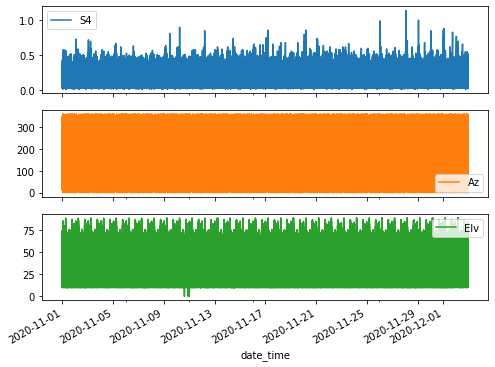

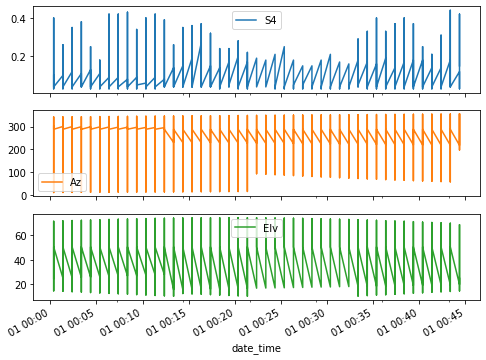

In [6]:
plot_cols = ['S4', 'Az', 'Elv']
plot_features = df[plot_cols]
plot_features.index = df['date_time']
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = df['date_time'][:480]
_ = plot_features.plot(subplots=True)

##Analizar para limpieza

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PRN,452987.0,28.850960,37.546005,1.00,9.00,19.00,27.00,138.00
S4,452987.0,0.099181,0.075309,0.02,0.05,0.07,0.12,1.14
Az,452987.0,190.824284,102.558542,0.00,111.80,201.50,288.40,360.00
Elv,452987.0,37.057117,17.537060,0.00,22.00,35.80,50.50,89.00


Text(0.5, 0, 'Az')

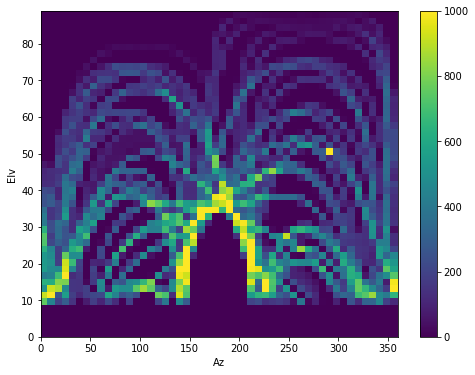

In [9]:
plt.hist2d( df['Az'],df['Elv'], bins=(50, 50), vmax=1000)
plt.colorbar()
plt.ylabel('Elv')
plt.xlabel('Az')

In [10]:
# Convert to radians.
az_rad = df.pop('Az')*np.pi / 180

# Calculate the wind x and y components.
az_x = np.cos(az_rad)
az_y = np.sin(az_rad)

elv_rad = np.sin(df.pop('Elv')*np.pi / 180)


df['Pro-x']=az_x *elv_rad
df['Pro-y']=az_y *elv_rad


# Calculate the max wind x and y components.
#df['max Wx'] = max_wv*np.cos(wd_rad)
#df['max Wy'] = max_wv*np.sin(wd_rad)

(-0.9952392283310815,
 0.9591531608722451,
 -0.999692367338443,
 0.9844491990404233)

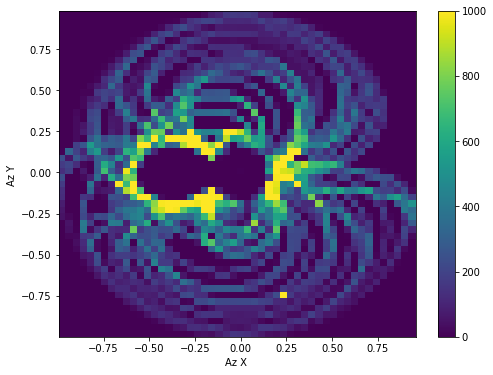

In [ ]:
plt.hist2d(df['Pro-x'], df['Pro-y'], bins=(50, 50), vmax=1000)
plt.colorbar()
plt.xlabel('Az X ')
plt.ylabel('Az Y ')
ax = plt.gca()
ax.axis('tight')

Extrayendo características cíclicas de tiempo

In [11]:
timestamp_s = df['date_time'].map(datetime.datetime.timestamp)


day = 24*60*60

year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Comportamiento de la señal')

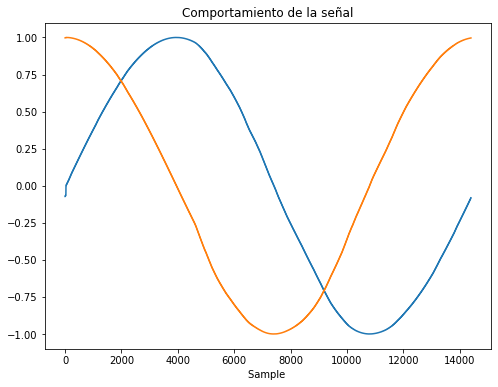

In [12]:
#Aparentemente se registran unos 10 a 11 satélites en cada obsrevación
plt.plot(np.array(df['Day sin'])[24*60*30:24*60*40]) #Segundos diarios=24*60*60, Frecuencia de muestreo=10s->Limite diario=24*60*10
plt.plot(np.array(df['Day cos'])[24*60*30:24*60*40])
plt.xlabel('Sample ')
plt.title('Comportamiento de la señal')

1604447002.0
1604447062.0
1604447122.0
1604533282.0


Text(0.5, 1.0, 'Time of day signal')

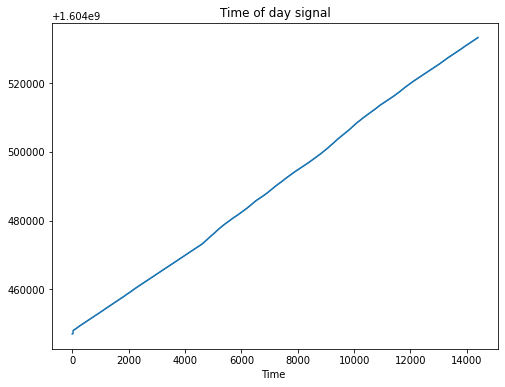

In [13]:
plt.plot(np.array(df['date_time'].map(datetime.datetime.timestamp)[24*60*30:24*60*40])) #Segundos diarios=24*60*60, Frecuencia de muestreo=10s->Limite diario=24*60*10
print(df['date_time'].map(datetime.datetime.timestamp)[24*60*30])
print(df['date_time'].map(datetime.datetime.timestamp)[24*60*30+10])
print(df['date_time'].map(datetime.datetime.timestamp)[24*60*30+20])
print(df['date_time'].map(datetime.datetime.timestamp)[24*60*40])
plt.xlabel('Time ')
plt.title('Time of day signal')

Esto le da al modelo acceso a las características de frecuencia más importantes. En este caso, sabía de antemano qué frecuencias eran importantes.

Si no lo sabía, puede determinar qué frecuencias son importantes usando un fft . Para comprobar nuestras suposiciones, aquí está el tf.signal.rfft de la temperatura a lo largo del tiempo. Tenga en cuenta los picos obvios en frecuencias cercanas a 1/year y 1/day

In [ ]:
#Este cpodigo aún debe ser adaptdo, en este punto existen "n" muestras para cada observación, además "n" es variable
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## División de datos

Usaremos una división (70%, 20%, 10%) para los conjuntos de entrenamiento, validación y prueba. Tenga en cuenta que los datos no se mezclan aleatoriamente antes de dividirlos. Esto es por dos razones.

 

1.   Garantiza que aún sea posible dividir los datos en ventanas de muestras consecutivas.
2.   Garantiza que los resultados de la validación / prueba sean más realistas y se evalúen en función de los datos recopilados después de que se entrenara el modelo.




In [20]:
df1=df
df=df.drop(['date_time'],axis=1)
df.head()

,PRN,S4,Pro-x,Pro-y,Day sin,Day cos,Year sin,Year cos
0,3,0.10,0.213777,-0.357196,0.0016,0.999999,-0.861636,0.507527
1,8,0.05,-0.691644,-0.244924,0.0016,0.999999,-0.861636,0.507527
2,10,0.40,-0.207385,0.134164,0.0016,0.999999,-0.861636,0.507527
3,11,0.08,-0.380023,-0.224745,0.0016,0.999999,-0.861636,0.507527
4,16,0.04,0.641509,-0.203499,0.0016,0.999999,-0.861636,0.507527


In [21]:
from sklearn.model_selection import train_test_split

column_indices = {name: i for i, name in enumerate(df.columns)}

#y=df['S4']
#X=df[['PRN','Pro-x','Pro-y','Day sin']]
n = len(df)

train_df, test_df = train_test_split(df, test_size=0.25, random_state=1)

train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=1) # 0.125 x 0.8 = 0.1

num_features = df.shape[1]

## Normalizar los datos

Es importante escalar características antes de entrenar una red neuronal. La normalización es una forma común de realizar esta escala. Reste la media y divida por la desviación estándar de cada característica.

La media y la desviación estándar solo deben calcularse utilizando los datos de entrenamiento para que los modelos no tengan acceso a los valores en los conjuntos de validación y prueba.

También se puede argumentar que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento durante el entrenamiento, y que esta normalización debería realizarse utilizando promedios móviles. Ese no es el enfoque de este tutorial, y los conjuntos de validación y prueba garantizan que obtenga métricas (algo) honestas. Entonces, en aras de la simplicidad, este tutorial utiliza un promedio simple.

In [ ]:
sklearn.preprocessing.scale(X, *, axis=0, with_mean=True, with_std=True, copy=True)

In [22]:
#No usamos el modulo de sklearn, debido a que nos da un ouput numpy y tendríamos que reconstruir nuestro dataframe

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
S4=df['S4'].values
time = np.arange(S4.size, dtype="float32")
print(time.size)
print(S4.size)

452987
452987
